### Autoreload

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [77]:
# Task models
from dlomix.models.chargestate import DominantChargeStatePredictor
from dlomix.models.chargestate import ObservedChargeStatePredictor
# Test models
from dlomix.models.experimental_chargestate import LSTMTest
from dlomix.models.experimental_chargestate import LayerTestChargePredictor
from dlomix.models.experimental_chargestate import PrositChargeStateAdaption
from dlomix.models.experimental_chargestate import DominantChargeStatePredictorTest
# Constants
from dlomix.constants import ALPHABET_UNMOD
# libraries
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import numpy as np 
# 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix

## Create dummy data

In [78]:
# read in parquet file
df = pd.read_parquet('../data/TUM_third_pool_meta_data.parquet')

In [79]:
# remove UNIMOD sequences
df = df[~df.modified_sequence.str.contains('UNIMOD')]

In [80]:
# randomly sample 10,000 rows
df = df.sample(10000)

In [81]:
# encode the sequences
df.modified_sequence = df.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

In [82]:
# determine the maximum sequence length in the dummy-dataset
max_len = df.modified_sequence.apply(len).max()
max_len

32

In [83]:
# pad sequences to max length with 0s
df.modified_sequence = df.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

In [84]:
# drop all column exept modified_sequence and precursor_charge
df = df[['modified_sequence', 'precursor_charge']]

In [85]:
# Split into features and labels
X = np.array(df.modified_sequence.to_list())
y = df['precursor_charge'].values

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Load preprocessed data

In [86]:
processed_data = pd.read_parquet("dlomix/data/processed_data.parquet")

In [87]:
processed_data.head()

,modified_sequence,precursor_charge,precursor_intensity,charge_by_max_intensity,max_intensity,charge_by_avg_intensity,avg_intensity,one_hot_most_abundant_charge,charge_state_vector,normalized_intensity_distribution
0,AAAAAAAAAAAAAAAAGLGLGP,"[2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, ...","[12746190.0, 2009914.0, 12746190.0, 791369.9, ...",2,84118390.0,2,3.728121e+07,"[0, 1, 0, 0, 0, 0]","[1, 1, 1, 0, 0, 0]","[0.001471512299483296, 0.9705152992903665, 0.0..."
1,AAAAAAAAAAAAAAAASAGGK,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[5944787.0, 5944787.0, 8502878.0, 6425294.0, 8...",2,8824163.0,2,7.146815e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2,AAAAAAAAAAAAAAAGAGAGAK,"[2, 2, 2, 2]","[3067981.0, 3067981.0, 3067981.0, 3067981.0]",2,3067981.0,2,3.067981e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,AAAAAAAAAAAAAAASGFAYPGTSER,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[11913300.0, 11913300.0, 11913300.0, 11913300....",2,11913300.0,2,7.432984e+06,"[0, 1, 0, 0, 0, 0]","[0, 1, 1, 0, 0, 0]","[0.0, 0.9722393807278517, 0.027760619272148377..."
4,AAAAAAAAAAAAAAG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1573785.0, 4638296.0, 7934979.0, 2019978.0, 4...",1,16573010.0,1,5.697398e+06,"[1, 0, 0, 0, 0, 0]","[1, 0, 0, 0, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [88]:
len(processed_data)

830376

In [89]:
simplified_processed_data = processed_data.sample(100000)

In [90]:
# remove UNIMOD sequences
simplified_processed_data = processed_data[~processed_data.modified_sequence.str.contains('UNIMOD')]

In [91]:
# encode the sequences
simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))

/tmp/ipykernel_2106/390376040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(list).apply(lambda x: np.array([ALPHABET_UNMOD[aa] for aa in x]))


In [92]:
# determine the maximum sequence length in the dummy-dataset
max_len = simplified_processed_data.modified_sequence.apply(len).max()
max_len

43

In [93]:
# pad sequences to max length with 0s
simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))

/tmp/ipykernel_2106/266666972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simplified_processed_data.modified_sequence = simplified_processed_data.modified_sequence.apply(lambda x: np.pad(x, (0, max_len - len(x)), constant_values=0))


In [94]:
# drop all column exept modified_sequence and precursor_charge
simplified_processed_data = simplified_processed_data[['modified_sequence', 'one_hot_most_abundant_charge', 'charge_state_vector', 'normalized_intensity_distribution']]

In [95]:
X = np.array(simplified_processed_data.modified_sequence.to_list())
y = np.array(simplified_processed_data['one_hot_most_abundant_charge'].tolist())

# 70/20/10 split for training, validation and test
# First split: training and test+validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Check the shape of the splits
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (403757, 43) (403757, 6)
Validation set shape: (115360, 43) (115360, 6)
Test set shape: (57680, 43) (57680, 6)


### Create model objects

In [96]:
majority_model = DominantChargeStatePredictor()
majority_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [97]:
observed_model = ObservedChargeStatePredictor()
observed_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [98]:
lstm_model_test = LSTMTest()
lstm_model_test.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [99]:
all_of_it_test_model = LayerTestChargePredictor(seq_length=max_len)
all_of_it_test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [100]:
prosit_adaption_model = PrositChargeStateAdaption(seq_length=max_len)
prosit_adaption_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [101]:
majority_model_2 = DominantChargeStatePredictorTest(num_classes=6, seq_length=max_len)
majority_model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

### Regularization

In [102]:
# regularisation: early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

In [103]:
# Function to decay the learning rate
def scheduler(epoch, lr):
    if epoch < 4:
        return lr
    else:
        return lr * np.exp(-0.1)

decaying_lr = LearningRateScheduler(scheduler)

### Train models on dummy data

In [56]:
prosit_model_history = prosit_adaption_model.fit(X_train, y_train,epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
Shape of inputs:  (None, 43)
Shape after embedding:  (None, 43, 64)
Shape after encoder:  (None, 43, 512)
Shape after attention:  (None, 512)
Shape after flatten:  (None, 512)
Shape after dense1:  (None, 64)
Shape after regressor:  (None, 512)
Shape of output:  (None, 6)
Shape of inputs:  (None, 43)
Shape after embedding:  (None, 43, 64)
Shape after encoder:  (None, 43, 512)
Shape after attention:  (None, 512)
Shape after flatten:  (None, 512)
Shape after dense1:  (None, 64)
Shape after regressor:  (None, 512)
Shape of output:  (None, 6)
28839/28840 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8987Shape of inputs:  (16, 43)
Shape after embedding:  (16, 43, 64)
Shape after encoder:  (16, 43, 512)
Shape after attention:  (16, 512)
Shape after flatten:  (16, 512)
Shape after dense1:  (16, 64)
Shape after regressor:  (16, 512)
Shape of output:  (16, 6)
28840/28840 [==============================] - 413s 14ms/step - loss: 0.2834 - accuracy: 0.8987 - va

In [34]:
majority_model_2_history = majority_model.fit(X_train, y_train,epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100


2024-04-04 10:32:07.040710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-04 10:32:07.482242: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f27228f1bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-04 10:32:07.482266: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-04-04 10:32:07.493554: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712219527.556309   48456 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28840/28840 [==============================] - 237s 8ms/step - loss: 0.3051 - accuracy: 0.8925 - val_loss: 0.2443 - val_accuracy: 0.9151
Epoch 2/100
28840/28840 [==============================] - 231s 8ms/step - loss: 0.2641 - accuracy: 0.9104 - val_loss: 0.2383 - val_accuracy: 0.9184
Epoch 3/100
28840/28840 [==============================] - 234s 8ms/step - loss: 0.2575 - accuracy: 0.9132 - val_loss: 0.2317 - val_accuracy: 0.9208
Epoch 4/100
28840/28840 [==============================] - 231s 8ms/step - loss: 0.2554 - accuracy: 0.9141 - val_loss: 0.2416 - val_accuracy: 0.9183
Epoch 5/100
28840/28840 [==============================] - 232s 8ms/step - loss: 0.2545 - accuracy: 0.9148 - val_loss: 0.2326 - val_accuracy: 0.9222
Epoch 6/100
28840/28840 [==============================] - 239s 8ms/step - loss: 0.2559 - accuracy: 0.9138 - val_loss: 0.2433 - val_accuracy: 0.9140
Epoch 7/100
28840/28840 [==============================] - 232s 8ms/step - loss: 0.2569 - accuracy: 0.9137 - val_loss:

In [104]:
majority_model_2_LR_history = majority_model_2.fit(X_train, y_train,epochs=50, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping, decaying_lr])

Epoch 1/50
25235/25235 [==============================] - 212s 8ms/step - loss: 0.3067 - accuracy: 0.8925 - val_loss: 0.2604 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 2/50
25235/25235 [==============================] - 221s 9ms/step - loss: 0.2665 - accuracy: 0.9101 - val_loss: 0.2442 - val_accuracy: 0.9166 - lr: 0.0010
Epoch 3/50
25235/25235 [==============================] - 225s 9ms/step - loss: 0.2608 - accuracy: 0.9126 - val_loss: 0.2380 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 4/50
25235/25235 [==============================] - 232s 9ms/step - loss: 0.2579 - accuracy: 0.9137 - val_loss: 0.2415 - val_accuracy: 0.9191 - lr: 0.0010
Epoch 5/50
25235/25235 [==============================] - 230s 9ms/step - loss: 0.2532 - accuracy: 0.9154 - val_loss: 0.2315 - val_accuracy: 0.9204 - lr: 9.0484e-04
Epoch 6/50
25235/25235 [==============================] - 231s 9ms/step - loss: 0.2496 - accuracy: 0.9166 - val_loss: 0.2301 - val_accuracy: 0.9220 - lr: 8.1873e-04
Epoch 7/50
25235/25235 [==

### Reporting

In [111]:
def plot_learning_curves(history, title='Learning Curves'):
    """Plot the learning curves for training and validation loss and accuracy. 
    Args:
    - history: Return value from model.fit().
    - title (optional): Base title for the plots. It will be appended with "Loss" and "Accuracy" for the respective plots.
    """
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Dynamically find accuracy keys in history_dict
    accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and not key.startswith('val_')), None)
    val_accuracy_key = next((key for key in history_dict.keys() if 'acc' in key and key.startswith('val_')), None)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot training and validation loss
    ax1.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy if keys exist
    if accuracy_key and val_accuracy_key:
        accuracy = history_dict[accuracy_key]
        val_accuracy = history_dict[val_accuracy_key]
        ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
        ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
        ax2.set_title(f'{title} - Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        ax2.set_title(f'{title} - Accuracy Not Available')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.text(0.5, 0.5, 'Accuracy data not found in history', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()

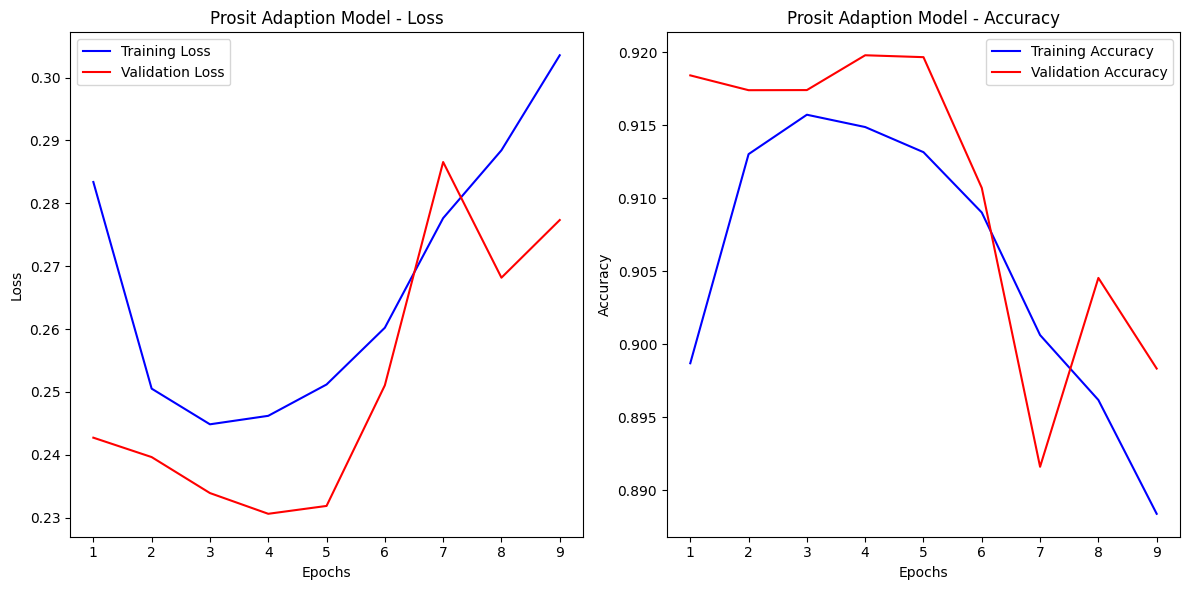

In [60]:
plot_learning_curves(prosit_model_history, title='Prosit Adaption Model')

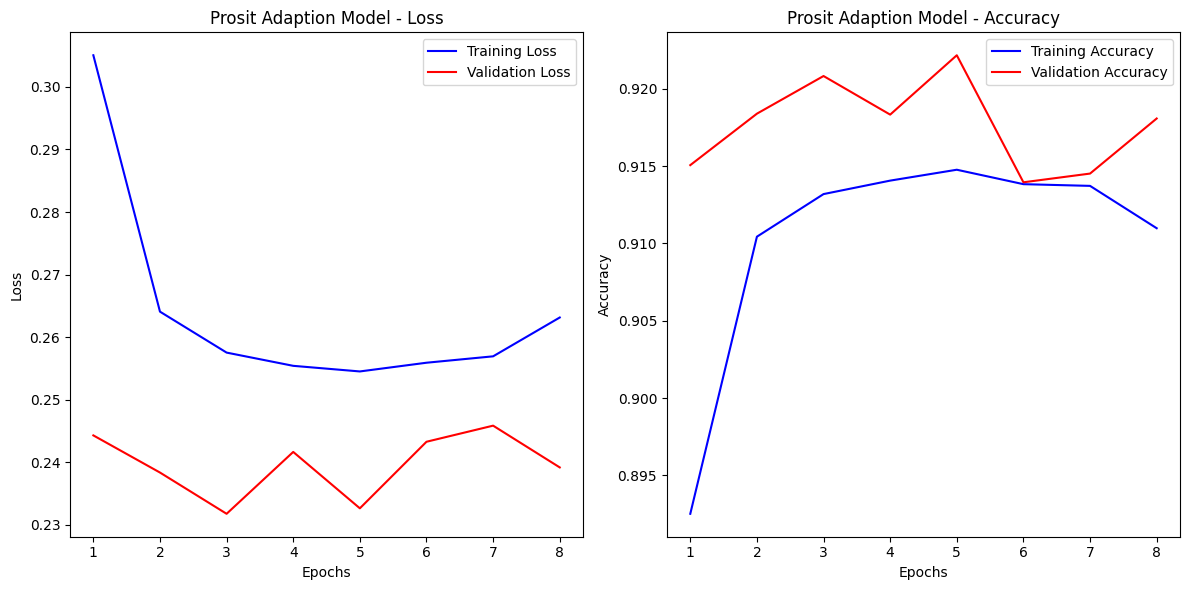

In [107]:
plot_learning_curves(majority_model_2_history, title='Prosit Adaption Model')

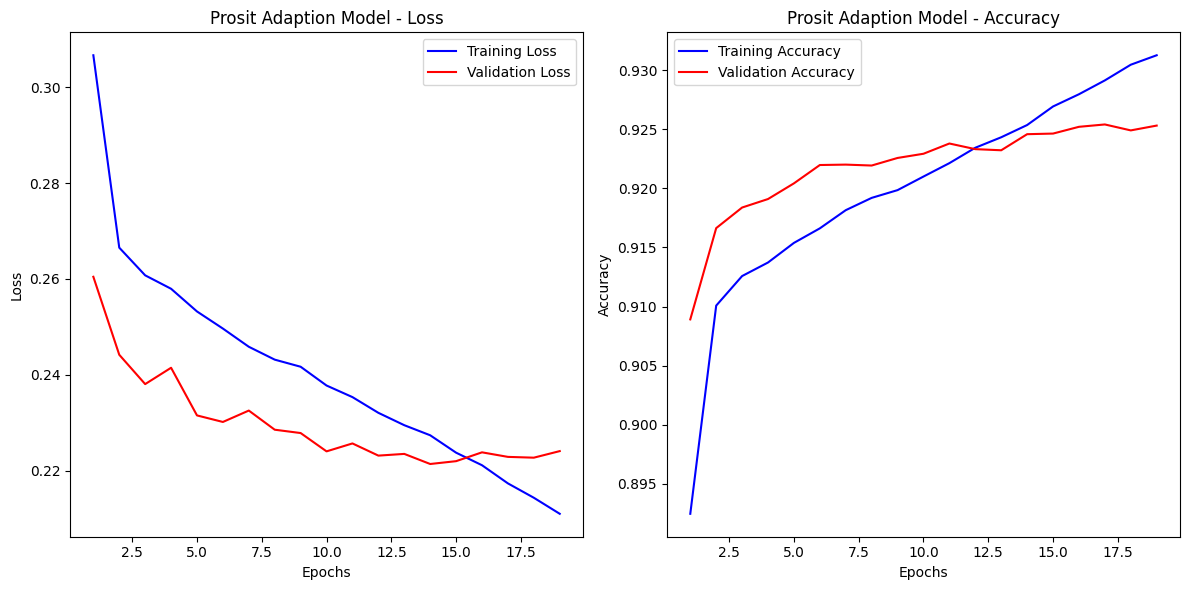

In [112]:
plot_learning_curves(majority_model_2_LR_history, title='Prosit Adaption Model')

In [115]:
def evaluate_model(model, X_test, y_test):
    # Predict classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print('#################################')
    print(model.summary())
    print('#################################')
    # Print the classification report
    print(classification_report(y_true, y_pred_classes))
    print('#################################')
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(np.unique(y_true)))
    plt.xticks(tick_marks, np.unique(y_true), rotation=45)
    plt.yticks(tick_marks, np.unique(y_true))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

1803/1803 [==============================] - 5s 3ms/step
#################################
Model: "dominant_charge_state_predictor_test_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    multiple                  1408      
                                                                 
 gru_12 (GRU)                multiple                  247296    
                                                                 
 dropout_21 (Dropout)        multiple                  0         
                                                                 
 gru_13 (GRU)                multiple                  148224    
                                                                 
 attention_layer_6 (Attenti  multiple                  171       
 onLayer)                                                        
                                                                 
 fl

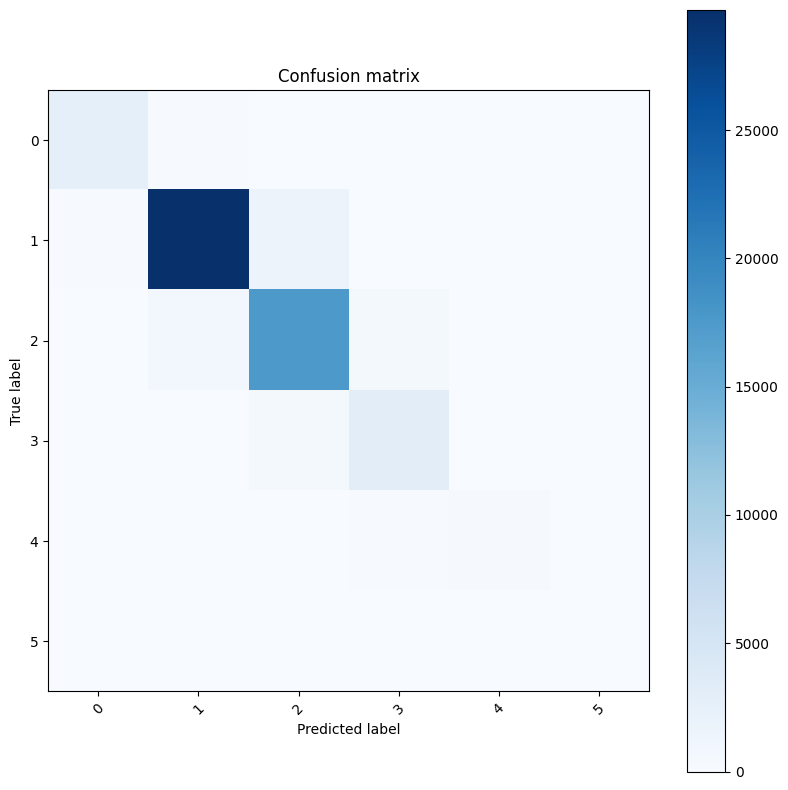

In [116]:
evaluate_model(majority_model_2, X_test, y_test)

### GPU test

In [30]:
import tensorflow as tf

In [59]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
history_5 = prosit_adaption_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), callbacks=[early_stopping])